In [13]:
from __future__ import absolute_import, division, print_function, unicode_literals

from tensorflow import keras
### hack tf-keras to appear as top level keras
import sys
sys.modules['keras'] = keras
### end of hack

import keras.backend as K
from keras.utils import multi_gpu_model
from keras.callbacks import TensorBoard

from sklearn.model_selection import KFold

import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, callbacks
from keras.callbacks import *
from keras.models import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras.optimizers import SGD, Adam
import numpy as np
import pprint
import os
from os import listdir
from os.path import isfile, join
from datetime import datetime
from sklearn.metrics import confusion_matrix

from keras.utils import plot_model
import matplotlib.pyplot as plt

# Importing custom framework
import sys, os
sys.path.insert(0, os.path.abspath('../..'))
from data_split import prepare_data_waveform

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""


In [23]:
def plot_confusion_matrix(cm,
                          target_names=[0,1,2,3,4,5,6,7,8,9],
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(11, 11))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "white")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "white")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [2]:
def build_cnn():
    #conv3-100,maxpool2, conv3-64, maxpool2, conv3-128, maxpool2, conv3-128,maxpool2,  conv3-128,  
    #maxpool2,  conv3-128,  maxpool2,  FC-1024FC-512, FC-10
    
    model = keras.models.Sequential([
        keras.layers.Conv1D(filters=100, kernel_size=3, strides=1, activation='relu', input_shape=(8000, 1)),
        #keras.layers.BatchNormalization(),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, activation='relu', padding="same"),
        #keras.layers.BatchNormalization(),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding="same"),
        #keras.layers.BatchNormalization(),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding="same"),
        #keras.layers.BatchNormalization(),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding="same"),
        #keras.layers.BatchNormalization(),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding="same"),
        #keras.layers.BatchNormalization(),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        
        keras.layers.Flatten(),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation='softmax')
    ])
    return model

In [3]:
waveformPath = '../../merged/waveform.hdf5'
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data_waveform(waveformPath)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[2], X_train.shape[1])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[2], X_val.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2], X_test.shape[1])

In [4]:
import gc
gc.collect()
K.clear_session()
tf.compat.v1.reset_default_graph()
X_train.shape

(18000, 8000, 1)

In [5]:
#tf.reset_default_graph()

tbCallBack = TensorBoard(log_dir='logs', histogram_freq=1,
                         write_graph=True,
                         write_grads=True,
                         write_images=True)


# Experiment 1 (AudioNet)

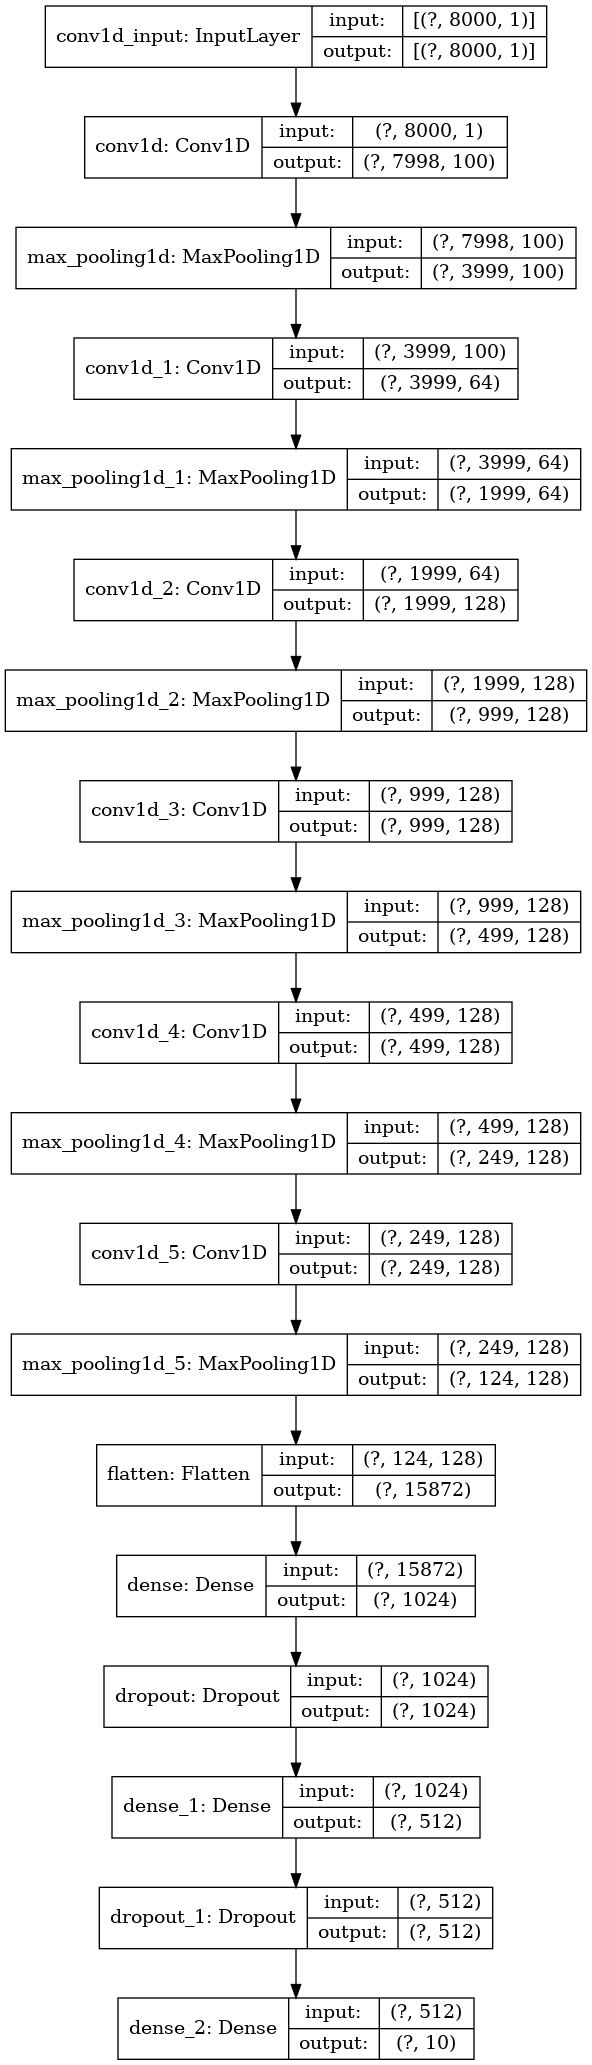

In [6]:
model = build_cnn()
plot_model(model, to_file='CNN_Experiment1.png', show_shapes=True, show_layer_names=True)

In [7]:
K.clear_session()
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
opt = SGD(lr=0.001, momentum=0.9, clipvalue=5)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

filepath = "logs/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

training_history = model.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val),batch_size=100, callbacks=[earlyStopping, tbCallBack], shuffle=False)
    
val_scores = model.evaluate(X_val, y_val, verbose=0)
print(val_scores)

Epoch 1/200
180/180 [==============================] - 199s 1s/step - loss: 2.2659 - accuracy: 0.1207 - val_loss: 2.2035 - val_accuracy: 0.1697
Epoch 2/200
180/180 [==============================] - 199s 1s/step - loss: 2.1381 - accuracy: 0.2109 - val_loss: 2.0229 - val_accuracy: 0.2875
Epoch 3/200
180/180 [==============================] - 198s 1s/step - loss: 1.9929 - accuracy: 0.2733 - val_loss: 1.9123 - val_accuracy: 0.2955
Epoch 4/200
180/180 [==============================] - 199s 1s/step - loss: 1.8933 - accuracy: 0.3148 - val_loss: 1.8416 - val_accuracy: 0.3143
Epoch 5/200
180/180 [==============================] - 199s 1s/step - loss: 1.8144 - accuracy: 0.3418 - val_loss: 1.7658 - val_accuracy: 0.3370
Epoch 6/200
180/180 [==============================] - 198s 1s/step - loss: 1.7462 - accuracy: 0.3682 - val_loss: 1.6857 - val_accuracy: 0.3673
Epoch 7/200
180/180 [==============================] - 198s 1s/step - loss: 1.6185 - accuracy: 0.4233 - val_loss: 1.6342 - val_accuracy:

180/180 [==============================] - 200s 1s/step - loss: 0.1641 - accuracy: 0.9367 - val_loss: 0.4585 - val_accuracy: 0.8527
Epoch 58/200
180/180 [==============================] - 204s 1s/step - loss: 0.1635 - accuracy: 0.9365 - val_loss: 0.4722 - val_accuracy: 0.8467
Epoch 59/200
180/180 [==============================] - 204s 1s/step - loss: 0.1601 - accuracy: 0.9376 - val_loss: 0.4765 - val_accuracy: 0.8493
Epoch 60/200
180/180 [==============================] - 206s 1s/step - loss: 0.1547 - accuracy: 0.9409 - val_loss: 0.4715 - val_accuracy: 0.8518
Epoch 61/200
180/180 [==============================] - 204s 1s/step - loss: 0.1490 - accuracy: 0.9421 - val_loss: 0.4607 - val_accuracy: 0.8497
Epoch 62/200
180/180 [==============================] - 208s 1s/step - loss: 0.1510 - accuracy: 0.9397 - val_loss: 0.4464 - val_accuracy: 0.8535
Epoch 63/200
180/180 [==============================] - 207s 1s/step - loss: 0.1437 - accuracy: 0.9457 - val_loss: 0.4691 - val_accuracy: 0.851

180/180 [==============================] - 207s 1s/step - loss: 0.0216 - accuracy: 0.9933 - val_loss: 0.5593 - val_accuracy: 0.8813
Epoch 114/200
180/180 [==============================] - 207s 1s/step - loss: 0.0194 - accuracy: 0.9936 - val_loss: 0.5732 - val_accuracy: 0.8700
Epoch 115/200
180/180 [==============================] - 203s 1s/step - loss: 0.0216 - accuracy: 0.9936 - val_loss: 0.5623 - val_accuracy: 0.8747
Epoch 116/200
180/180 [==============================] - 202s 1s/step - loss: 0.0209 - accuracy: 0.9940 - val_loss: 0.5093 - val_accuracy: 0.8823
Epoch 117/200
180/180 [==============================] - 200s 1s/step - loss: 0.0182 - accuracy: 0.9946 - val_loss: 0.5420 - val_accuracy: 0.8807
Epoch 118/200
180/180 [==============================] - 204s 1s/step - loss: 0.0194 - accuracy: 0.9938 - val_loss: 0.5130 - val_accuracy: 0.8808
Epoch 119/200
180/180 [==============================] - 204s 1s/step - loss: 0.0193 - accuracy: 0.9932 - val_loss: 0.4897 - val_accuracy:

180/180 [==============================] - 197s 1s/step - loss: 0.0066 - accuracy: 0.9979 - val_loss: 0.5439 - val_accuracy: 0.8932
Epoch 170/200
180/180 [==============================] - 205s 1s/step - loss: 0.0067 - accuracy: 0.9981 - val_loss: 0.5509 - val_accuracy: 0.8943
Epoch 171/200
180/180 [==============================] - 204s 1s/step - loss: 0.0070 - accuracy: 0.9981 - val_loss: 0.5514 - val_accuracy: 0.8963
Epoch 172/200
180/180 [==============================] - 203s 1s/step - loss: 0.0060 - accuracy: 0.9983 - val_loss: 0.5248 - val_accuracy: 0.8935
Epoch 173/200
180/180 [==============================] - 201s 1s/step - loss: 0.0051 - accuracy: 0.9985 - val_loss: 0.5341 - val_accuracy: 0.8958
Epoch 174/200
180/180 [==============================] - 199s 1s/step - loss: 0.0060 - accuracy: 0.9984 - val_loss: 0.5508 - val_accuracy: 0.8937
Epoch 175/200
180/180 [==============================] - 198s 1s/step - loss: 0.0086 - accuracy: 0.9973 - val_loss: 0.5515 - val_accuracy:

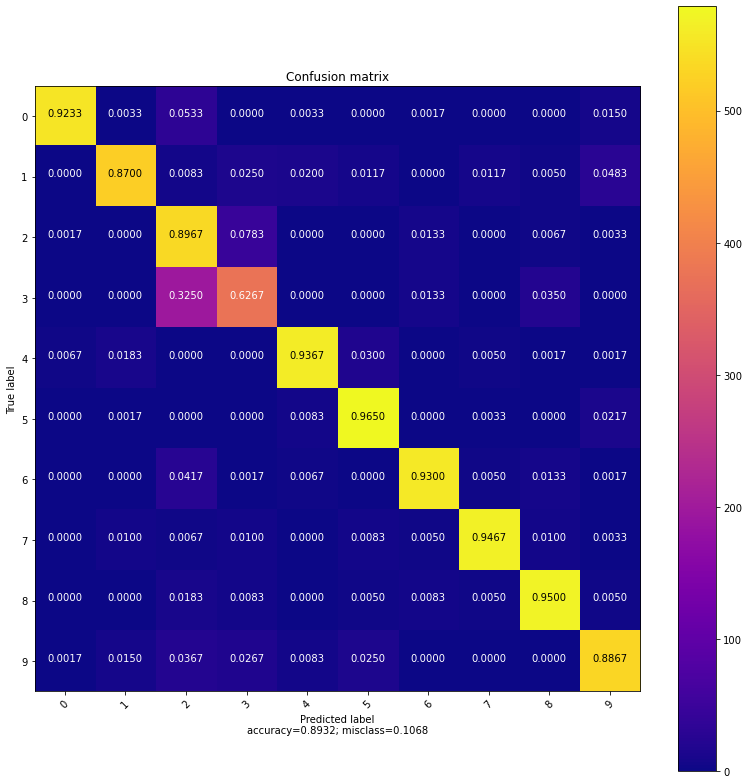

In [24]:
cm = confusion_matrix(y_true=y_val, y_pred=np.argmax(model.predict(X_val), axis=-1))
plot_confusion_matrix(cm, cmap='plasma')

In [25]:
print(model.evaluate(X_test, y_test, verbose=0))

[0.6587716341018677, 0.9054999947547913]


# Experiment 2

In [26]:
model = build_cnn()
#plot_model(model, to_file='CNN_Experiment2.png', show_shapes=True, show_layer_names=True)

In [27]:
K.clear_session()
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

filepath = "logs/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

training_history = model.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val),batch_size=100, callbacks=[earlyStopping, tbCallBack], shuffle=False)
    
val_scores = model.evaluate(X_val, y_val, verbose=0)
print(val_scores)

Epoch 1/200
180/180 [==============================] - 204s 1s/step - loss: 1.8461 - accuracy: 0.3241 - val_loss: 1.6572 - val_accuracy: 0.4855
Epoch 2/200
180/180 [==============================] - 203s 1s/step - loss: 1.1161 - accuracy: 0.5931 - val_loss: 2.3386 - val_accuracy: 0.4870
Epoch 3/200
180/180 [==============================] - 202s 1s/step - loss: 0.6942 - accuracy: 0.7436 - val_loss: 1.1054 - val_accuracy: 0.6693
Epoch 4/200
180/180 [==============================] - 201s 1s/step - loss: 0.4399 - accuracy: 0.8488 - val_loss: 0.8439 - val_accuracy: 0.7870
Epoch 5/200
180/180 [==============================] - 203s 1s/step - loss: 0.3008 - accuracy: 0.9048 - val_loss: 0.7174 - val_accuracy: 0.7997
Epoch 6/200
180/180 [==============================] - 202s 1s/step - loss: 0.2268 - accuracy: 0.9287 - val_loss: 0.3982 - val_accuracy: 0.8878
Epoch 7/200
180/180 [==============================] - 201s 1s/step - loss: 0.1377 - accuracy: 0.9561 - val_loss: 0.5744 - val_accuracy:

180/180 [==============================] - 199s 1s/step - loss: 0.0114 - accuracy: 0.9972 - val_loss: 0.2205 - val_accuracy: 0.9590
Epoch 58/200
180/180 [==============================] - 198s 1s/step - loss: 0.0051 - accuracy: 0.9986 - val_loss: 0.2881 - val_accuracy: 0.9550
Epoch 59/200
180/180 [==============================] - 198s 1s/step - loss: 0.0120 - accuracy: 0.9972 - val_loss: 0.4262 - val_accuracy: 0.9355
[0.4261651337146759, 0.9355000257492065]


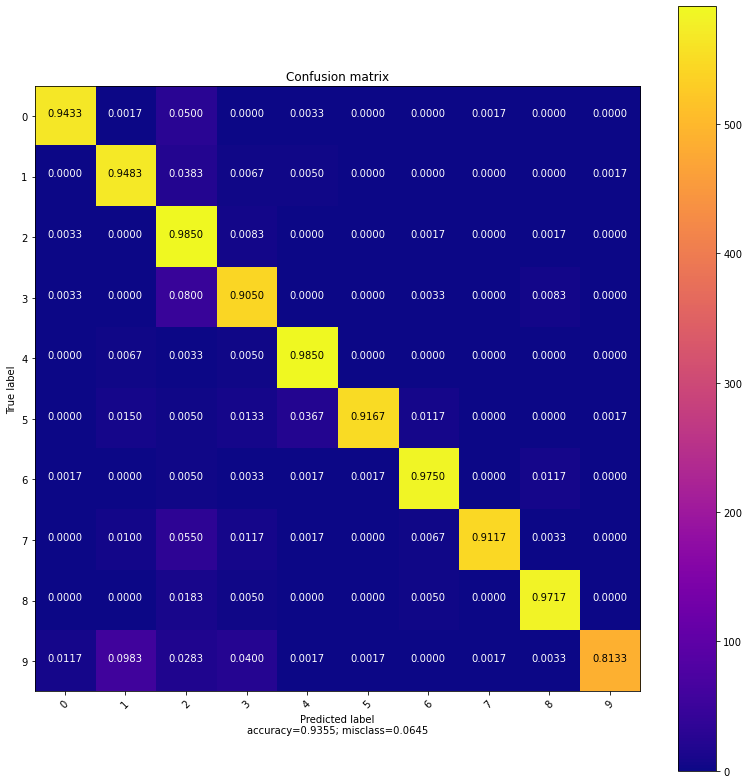

In [28]:
cm = confusion_matrix(y_true=y_val, y_pred=np.argmax(model.predict(X_val), axis=-1))
plot_confusion_matrix(cm, cmap='plasma')

In [29]:
print(model.evaluate(X_test, y_test, verbose=0))

[0.3653964698314667, 0.9576666951179504]


# Experiment 3

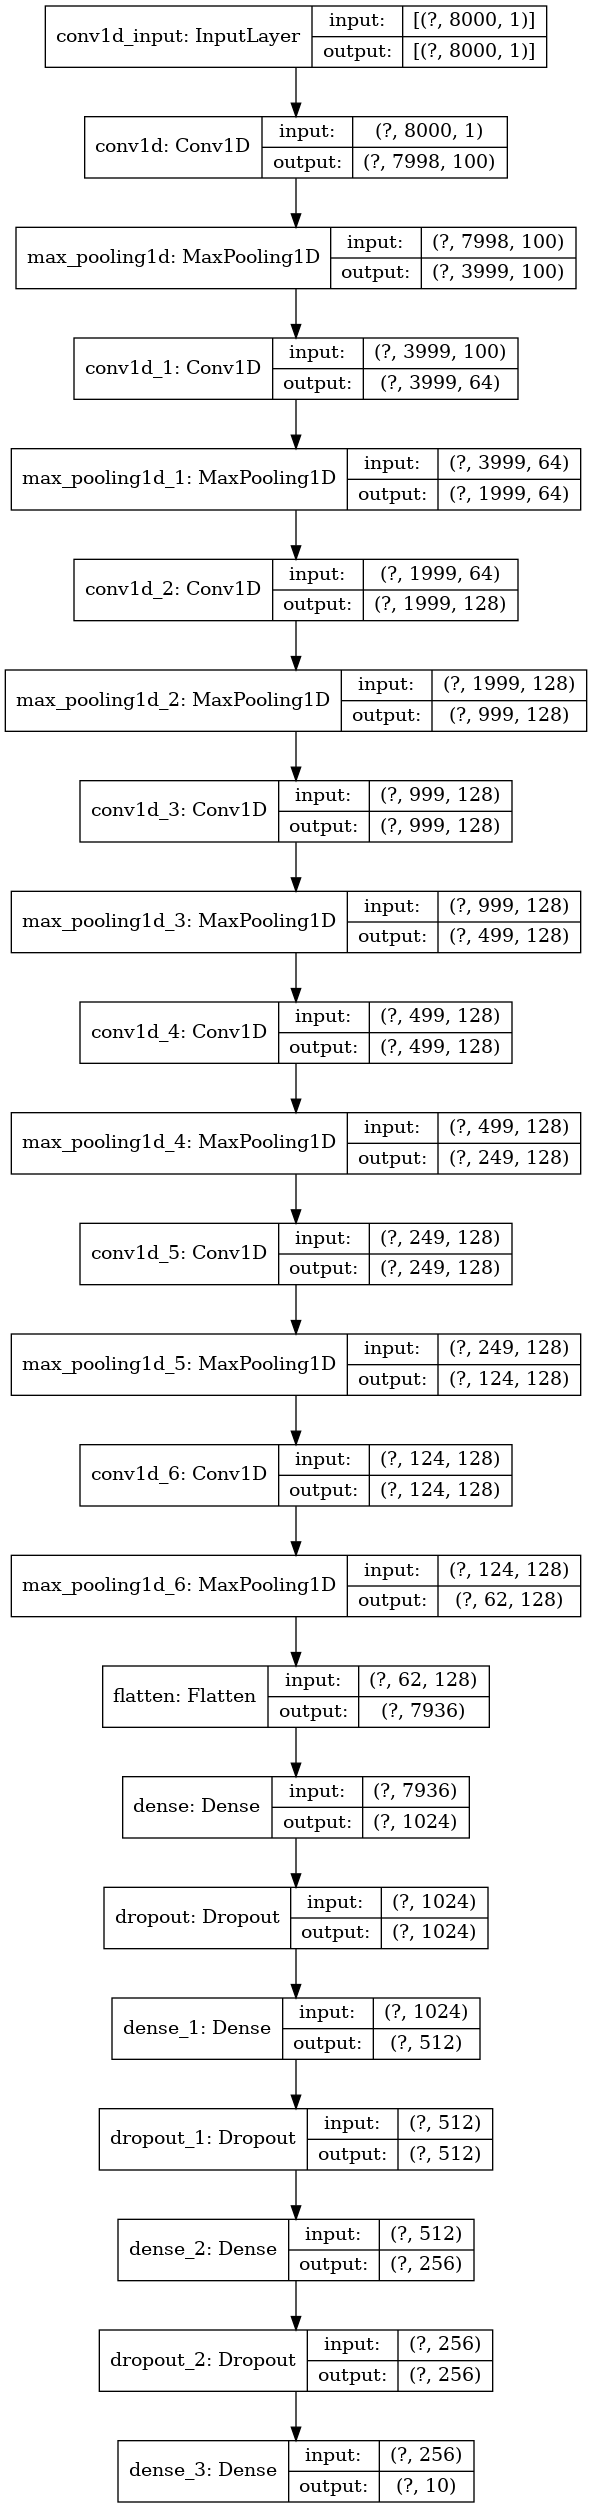

In [30]:
model = keras.models.Sequential([
        keras.layers.Conv1D(filters=100, kernel_size=3, strides=1, activation='relu', input_shape=(8000, 1)),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, activation='relu', padding="same"),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding="same"),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding="same"),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding="same"),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding="same"),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding="same"),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        
        keras.layers.Flatten(),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation='softmax')
    ])
plot_model(model, to_file='CNN_Experiment3.png', show_shapes=True, show_layer_names=True)

In [31]:
K.clear_session()
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

filepath = "logs/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

training_history = model.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val),batch_size=100, callbacks=[earlyStopping, tbCallBack], shuffle=False)
    
val_scores = model.evaluate(X_val, y_val, verbose=0)
print(val_scores)

Epoch 1/200
180/180 [==============================] - 199s 1s/step - loss: 2.0502 - accuracy: 0.2072 - val_loss: 2.3352 - val_accuracy: 0.2000
Epoch 2/200
180/180 [==============================] - 198s 1s/step - loss: 1.5824 - accuracy: 0.3528 - val_loss: 2.4710 - val_accuracy: 0.2588
Epoch 3/200
180/180 [==============================] - 198s 1s/step - loss: 1.3159 - accuracy: 0.4553 - val_loss: 1.9976 - val_accuracy: 0.3328
Epoch 4/200
180/180 [==============================] - 198s 1s/step - loss: 1.0447 - accuracy: 0.5843 - val_loss: 1.0066 - val_accuracy: 0.6852
Epoch 5/200
180/180 [==============================] - 197s 1s/step - loss: 0.6012 - accuracy: 0.7898 - val_loss: 0.8034 - val_accuracy: 0.7873
Epoch 6/200
180/180 [==============================] - 196s 1s/step - loss: 0.4206 - accuracy: 0.8691 - val_loss: 0.6305 - val_accuracy: 0.8258
Epoch 7/200
180/180 [==============================] - 196s 1s/step - loss: 0.2859 - accuracy: 0.9165 - val_loss: 0.3929 - val_accuracy:

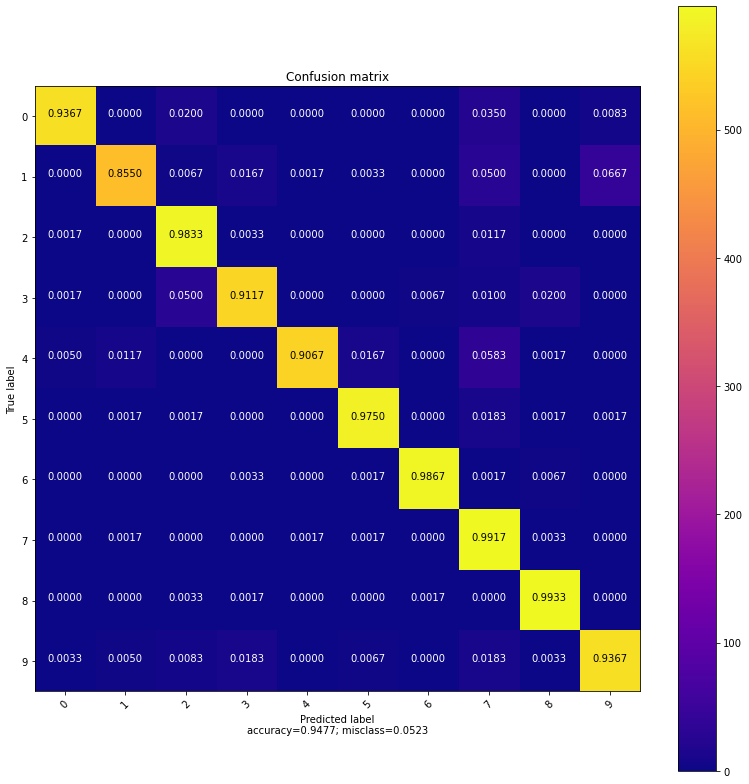

In [32]:
cm = confusion_matrix(y_true=y_val, y_pred=np.argmax(model.predict(X_val), axis=-1))
plot_confusion_matrix(cm, cmap='plasma')

In [33]:
print(model.evaluate(X_test, y_test, verbose=0))

[0.517574667930603, 0.9290000200271606]


# Experiment 4

In [34]:
model = keras.models.Sequential([
        keras.layers.Conv1D(filters=100, kernel_size=3, strides=1, activation='relu', input_shape=(8000, 1)),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, activation='relu', padding="same"),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding="same"),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding="same"),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding="same"),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding="same"),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding="same"),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        
        keras.layers.Flatten(),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation='softmax')
    ])
#plot_model(model, to_file='CNN_Experiment3.png', show_shapes=True, show_layer_names=True)

In [35]:
K.clear_session()
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
opt = Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

filepath = "logs/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

training_history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),batch_size=100, callbacks=[earlyStopping, tbCallBack], shuffle=False)
    
val_scores = model.evaluate(X_val, y_val, verbose=0)
print(val_scores)

Epoch 1/100
180/180 [==============================] - 195s 1s/step - loss: 3.8602 - accuracy: 0.0951 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/100
180/180 [==============================] - 194s 1s/step - loss: 2.3029 - accuracy: 0.0958 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/100
180/180 [==============================] - 194s 1s/step - loss: 2.3028 - accuracy: 0.0854 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/100
180/180 [==============================] - 193s 1s/step - loss: 2.3028 - accuracy: 0.0888 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/100
180/180 [==============================] - 192s 1s/step - loss: 2.3028 - accuracy: 0.0886 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 6/100
180/180 [==============================] - 192s 1s/step - loss: 2.3028 - accuracy: 0.0886 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 7/100
180/180 [==============================] - 192s 1s/step - loss: 2.3028 - accuracy: 0.0887 - val_loss: 2.3026 - val_accuracy:

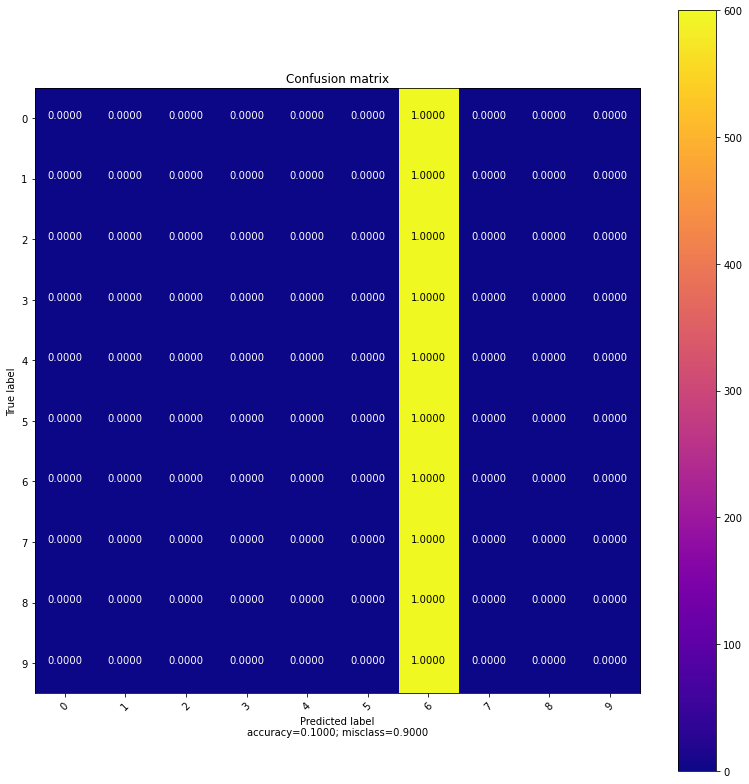

In [36]:
cm = confusion_matrix(y_true=y_val, y_pred=np.argmax(model.predict(X_val), axis=-1))
plot_confusion_matrix(cm, cmap='plasma')

In [37]:
print(model.evaluate(X_test, y_test, verbose=0))

[2.3025927543640137, 0.10000000149011612]


# Experiment 5

In [38]:
model = keras.models.Sequential([
        keras.layers.Conv1D(filters=100, kernel_size=3, strides=1, activation='relu', input_shape=(8000, 1)),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, activation='relu', padding="same"),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding="same"),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding="same"),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding="same"),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding="same"),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding="same"),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        
        keras.layers.Flatten(),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation='softmax')
    ])
#plot_model(model, to_file='CNN_Experiment3.png', show_shapes=True, show_layer_names=True)

In [39]:
K.clear_session()
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

filepath = "logs/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

training_history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),batch_size=100, callbacks=[earlyStopping, tbCallBack], shuffle=False)
    
val_scores = model.evaluate(X_val, y_val, verbose=0)
print(val_scores)

Epoch 1/100
180/180 [==============================] - 196s 1s/step - loss: 2.1581 - accuracy: 0.1894 - val_loss: 1.9579 - val_accuracy: 0.2713
Epoch 2/100
180/180 [==============================] - 196s 1s/step - loss: 1.6979 - accuracy: 0.3768 - val_loss: 1.4916 - val_accuracy: 0.4587
Epoch 3/100
180/180 [==============================] - 196s 1s/step - loss: 1.1844 - accuracy: 0.5686 - val_loss: 1.0432 - val_accuracy: 0.6447
Epoch 4/100
180/180 [==============================] - 195s 1s/step - loss: 0.8438 - accuracy: 0.6926 - val_loss: 0.7612 - val_accuracy: 0.7415
Epoch 5/100
180/180 [==============================] - 195s 1s/step - loss: 0.6816 - accuracy: 0.7488 - val_loss: 0.5527 - val_accuracy: 0.8140
Epoch 6/100
180/180 [==============================] - 194s 1s/step - loss: 0.5967 - accuracy: 0.7834 - val_loss: 0.4765 - val_accuracy: 0.8373
Epoch 7/100
180/180 [==============================] - 194s 1s/step - loss: 0.4869 - accuracy: 0.8274 - val_loss: 0.4687 - val_accuracy:

180/180 [==============================] - 193s 1s/step - loss: 0.0082 - accuracy: 0.9976 - val_loss: 0.2420 - val_accuracy: 0.9487
Epoch 58/100
180/180 [==============================] - 193s 1s/step - loss: 0.0072 - accuracy: 0.9983 - val_loss: 0.2537 - val_accuracy: 0.9450
Epoch 59/100
180/180 [==============================] - 192s 1s/step - loss: 0.0065 - accuracy: 0.9984 - val_loss: 0.1984 - val_accuracy: 0.9538
Epoch 60/100
180/180 [==============================] - 193s 1s/step - loss: 0.0072 - accuracy: 0.9978 - val_loss: 0.1673 - val_accuracy: 0.9633
Epoch 61/100
180/180 [==============================] - 198s 1s/step - loss: 0.0106 - accuracy: 0.9974 - val_loss: 0.1525 - val_accuracy: 0.9613
Epoch 62/100
180/180 [==============================] - 197s 1s/step - loss: 0.0067 - accuracy: 0.9983 - val_loss: 0.2596 - val_accuracy: 0.9372
Epoch 63/100
180/180 [==============================] - 196s 1s/step - loss: 0.0086 - accuracy: 0.9975 - val_loss: 0.1820 - val_accuracy: 0.955

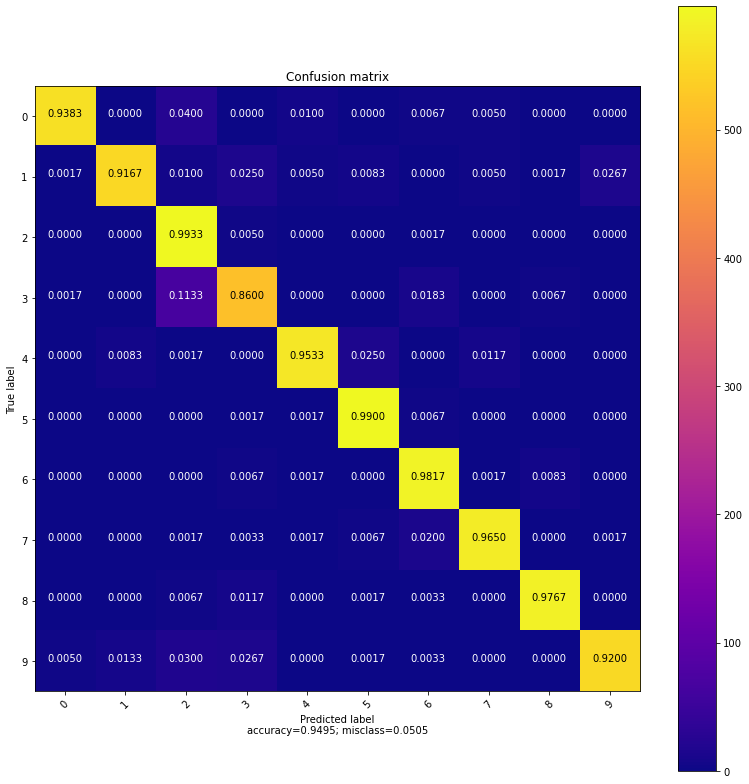

In [40]:
cm = confusion_matrix(y_true=y_val, y_pred=np.argmax(model.predict(X_val), axis=-1))
plot_confusion_matrix(cm, cmap='plasma')

In [41]:
print(model.evaluate(X_test, y_test, verbose=0))

[0.20815348625183105, 0.9613333344459534]
